### Interest Rates

**Objective**:   
After automating the processes of predicting accept/reject,loan grade, and subgrade, we are now ready to dive into our final task, which is predicting interest rates. We will be taking a similar approach as we did in the previous parts, which involves exploring our data,understanding which factors play a role in the determining interest rates, and building a model to automate this process.

**Imports & Data Overview**

In [1]:
import os

os.chdir(os.path.join(os.getcwd(), '..'))
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (MinMaxScaler,StandardScaler)
from project_utils.functions import (create_pipeline, create_preprocessor,
                                     extract_feature_importances,
                                     null_percentages,
                                     compute_correlations_and_pvalues,
                                     get_numerical_categorical_columns)
from project_utils.objective_functions import get_objective_xgb_regression
from tqdm import tqdm
import optuna
import xgboost as xgb
import shap
from plot_utils import annotate_bars, hide_spines

In [2]:
%load_ext autoreload
%autoreload 2
plt.style.use('deeplearning.mplstyle')
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_blue = default_colors[0]

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
df_accepted = pd.read_csv('lending_club_data/df_accepted_subset_cleaned.csv',
                          dtype={'zip_code': str},
                          low_memory=False).drop(columns=['fico_range_low','fico_range_high'])

In [5]:
float_types_accepted = df_accepted.select_dtypes(exclude='object').columns
df_accepted[float_types_accepted] = df_accepted[float_types_accepted].apply(
    lambda x: x.astype(np.float32))

**Interest Rate Distribution**

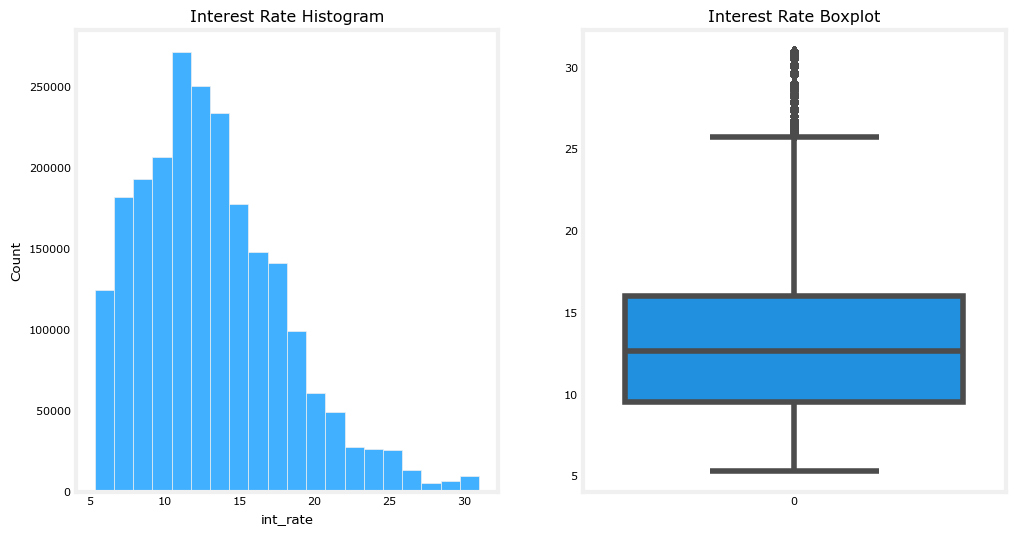

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Interest Rate Histogram')
sns.histplot(df_accepted['int_rate'], bins=20)
plt.subplot(1, 2, 2)
plt.title('Interest Rate Boxplot')
sns.boxplot(df_accepted['int_rate'])
plt.show()

In [16]:
df_accepted[(df_accepted['int_rate'] == 6)
            & ~df_accepted['grade'].isin(['A'])][[
                'int_rate', 'grade', 'term', 'sub_grade', 'application_type'
            ]].head(5)

,int_rate,grade,term,sub_grade,application_type
1098,6.0,D,36.0,D1,Individual
2136,6.0,C,36.0,C1,Individual
3107,6.0,C,36.0,C2,Individual
4247,6.0,F,60.0,F1,Individual
10191,6.0,D,36.0,D4,Individual


In [9]:
df_accepted[(df_accepted['int_rate'] == 6)
            & ~df_accepted['grade'].isin(['A'])].shape

(640, 85)

In [6]:
df_accepted = df_accepted[~(
    (df_accepted['int_rate'] == 6) & ~df_accepted['grade'].isin(['A']))]

In [19]:
df_accepted['int_rate'].describe()

count    2.245282e+06
mean     1.308533e+01
std      4.824316e+00
min      5.310000e+00
25%      9.490000e+00
50%      1.262000e+01
75%      1.599000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

- Our plots above display the distribution of interest rates. Our histogram displays a slightly skewed distribution where the mean of the interest rates is approximately 13. The box plot displays quite a few outliers where interest rates range from 25 to around 30-31. After investigating the lending club website, they stated that these ranges are normal for their interest rates, which indicates that these outliers should be left where they are not considered for removal. Another thing that came to our attention was that there are some data points that display  6% interest rates, but the risk and term assigned to the loans do not match up. For example loans with grade C,D,F,etc all with 6% interest rates. We will be removing those data points as they could skew the model and appear to be incorrect.

**Correlation**

In [20]:
corr_df = compute_correlations_and_pvalues(df_accepted, 'int_rate', 'pearson')

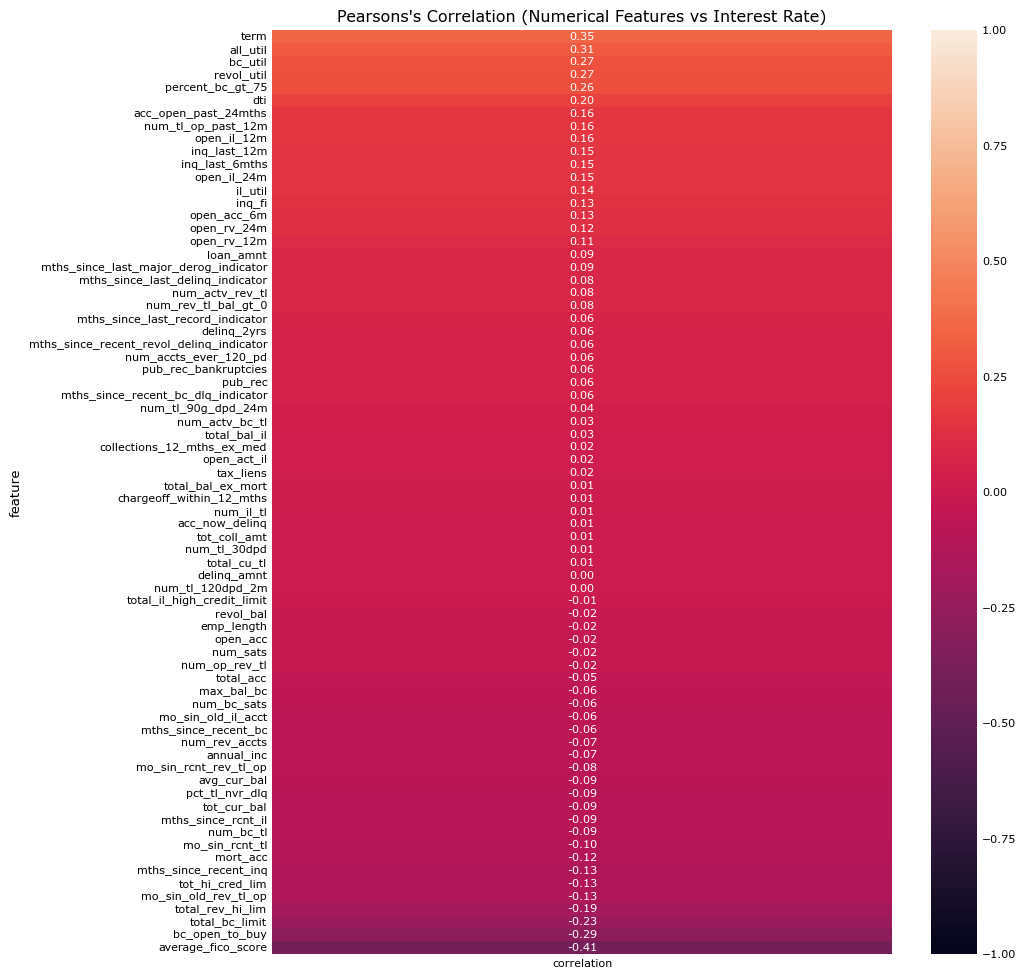

In [22]:
plt.figure(figsize=(10, 12))
sns.heatmap(corr_df.set_index('feature')[['correlation']],
            annot=True,
            fmt=".2f",
            vmin=-1,
            vmax=1)
plt.title("Pearsons's Correlation (Numerical Features vs Interest Rate)")
plt.show()

- We utilized pearsons correlation to identify realtionships between our numerical columns vs interest rate. We observe that variables such as term, average fico score, balance to credit limit on all trades(all_util), tatio of total current balance to high credit/credit limit for all bankcard accounts(bc_util), total open to buy on revolving bankcards (bc_open_to_buy) all display mild to strong correlations with interest rate. We also computed p-values for the correlation against our target. Due to the size of the dataset even a small amount of correlation gets deemed significant, almost every p-value was close to 0.

**Data Splitting/Preprocessing**

In [7]:
X = df_accepted.drop(columns=[
    'int_rate', 'earliest_cr_line', 'emp_title',
])
y = df_accepted['int_rate']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.075,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.075 /
                                                  (1 - 0.075),
                                                  random_state=42)

In [29]:
print(f"Training Data: {X_train.shape}")
print(f"Validation Data: {X_val.shape}")
print(f"Testing Data: {X_test.shape}")

Training Data: (1908488, 80)
Validation Data: (168397, 80)
Testing Data: (168397, 80)


In [30]:
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)
y_preds = dummy_regressor.predict(X_val)
print(f'Mean Squared Error: {mean_squared_error(y_val,y_preds)}')
print(
    f'Root Mean Squared Error: {mean_squared_error(y_val,y_preds,squared=False)}'
)

Mean Squared Error: 23.171159744262695
Root Mean Squared Error: 4.813642978668213


- Once again  split our data into train, test, and validation. We did an 85/7.5/7.5 split. This leaves us with a sufficient amount of data for training as well as testing and validation. We also created a baseline dummy model to give us some metrics to work against. Since we are focused on a regression task, we will be trying to minimize the MSE/RMSE which represents the average difference squared between the predicted and actual values. Minimizing the this value is import for improving the accuracy of our regression model as it helps us understand how far off our predictions are, on average, from the actual values.

**Model Selection**

In [31]:
numerical_cols, cat_cols = get_numerical_categorical_columns(X_train)

In [32]:
encoder = TargetEncoder()
numerical_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

In [33]:
models = {
    'XGBoost':
    xgb.XGBRegressor(random_state=42,
                     n_estimators=150,
                     objective='reg:squarederror',
                     max_depth=5),
    'RandomForest':
    RandomForestRegressor(random_state=42, n_estimators=150, max_depth=5),
    'LassoRegression':
    Lasso(random_state=42, max_iter=10_000, alpha=0.5),
    'LinearRegression':
    LinearRegression(),
}

In [34]:
preprocessor_tree_based = create_preprocessor(
    numerical_cols=numerical_cols,
    categorical_cols=cat_cols,
    imputer_numerical=numerical_imputer,
    imputer_categorical=cat_imputer,
    encoder=encoder,
    scaler=None)
preprocessor_linear = create_preprocessor(numerical_cols=numerical_cols,
                                          categorical_cols=cat_cols,
                                          imputer_numerical=numerical_imputer,
                                          imputer_categorical=cat_imputer,
                                          encoder=encoder,
                                          scaler=StandardScaler())

In [61]:
model_results = {}
feature_importances = {}
for model_name, model in tqdm(models.items()):
    if model_name in ['XGBoost', 'RandomForest']:
        pipeline = create_pipeline(model,
                                   preprocessor_tree_based,
                                   feature_selection=None)
    else:
        pipeline = create_pipeline(model,
                                   preprocessor_linear,
                                   feature_selection=None)
    pipeline.fit(X_train, y_train)
    y_preds = pipeline.predict(X_val)
    model_results[model_name] = [
        mean_squared_error(y_val, y_preds, squared=False),
        r2_score(y_val, y_preds)
    ]
    if model_name in ['XGBoost', 'RandomForest']:
        feature_importances[model_name] = extract_feature_importances(pipeline)

100%|████████████████████████████████████████████| 4/4 [57:19<00:00, 859.80s/it]


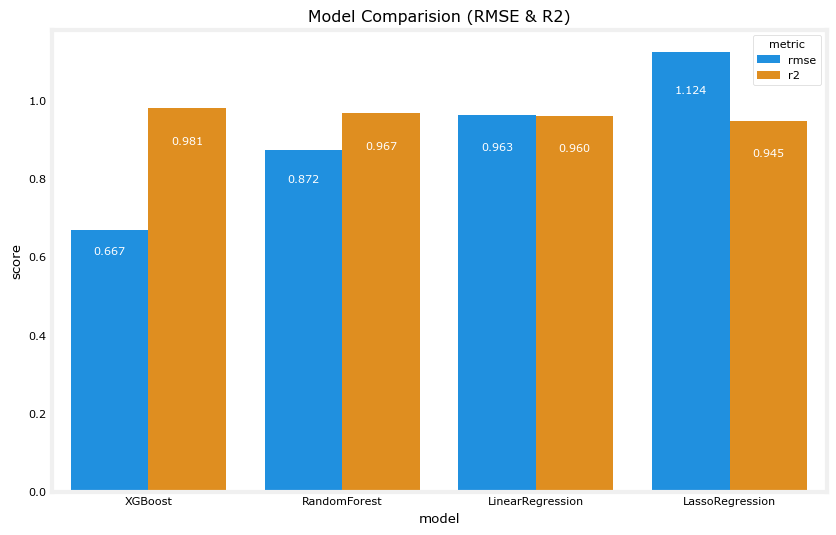

In [80]:
model_results_df = pd.DataFrame(model_results).T.reset_index().rename(columns={
    'index': 'model',
    0: 'rmse',
    1: 'r2'
}).sort_values(by='rmse')
plt.figure(figsize=(10, 6))
plt.title('Model Comparision (RMSE & R2)')
fig = sns.barplot(model_results_df.melt(id_vars=['model'],
                                        value_name='score',
                                        var_name='metric'),
                  x='model',
                  y='score',
                  hue='metric')
annotate_bars(fig, lim=0, offset_ratio=0.1)
plt.show()

In [53]:
cat_cols_mapping = {str(i): cat_cols[i] for i in range(len(cat_cols))}
xgb_ft_importance = feature_importances['XGBoost']
xgb_ft_importance['feature'] = xgb_ft_importance['feature'].str.replace(
    "^__", "", regex=True).map(lambda x: cat_cols_mapping.get(x, x))

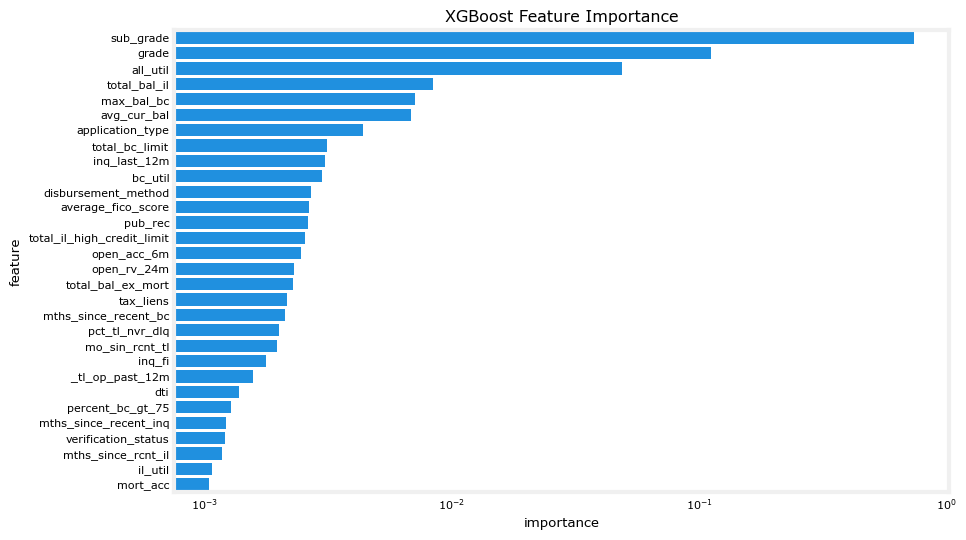

In [76]:
plt.figure(figsize=(10, 6))
plt.title('XGBoost Feature Importance')
sns.barplot(xgb_ft_importance.head(30),
            x='importance',
            y='feature',
            color=default_blue)
plt.xscale('log')
plt.show()

- Once again for our preprocessing we took a similar approach as we did our previous notebooks, creating preprocessing pipelines suited for our models that do and do not need scaling.

- After testing out various models like XGBoost , RandomForest, LinearRegression, and Lasso Regression, our XGBoost and Random forest perform best in terms of RMSE, both achieving quite good scores (0.67,0.8). Moving forward we will be using the XGBoost model as it performed the best. The feature importance plot shows that sub grade and grade where the biggest predictors (makes sense as interest rate is largely dependent on that) followed by balance to credit limit on all trades (all_util).

**Hyperparameter Tuning**

In [40]:
X_train_preprocessed = preprocessor_tree_based.fit_transform(X_train, y_train)
X_val_preprocessed = preprocessor_tree_based.transform(X_val)

In [41]:
objective_v1 = get_objective_xgb_regression(X_train_preprocessed,
                                            X_val_preprocessed, y_train, y_val,
                                            mean_squared_error)

In [44]:
optuna.logging.get_logger("optuna").setLevel(logging.WARNING)
study_xgb_v1 = optuna.create_study(direction='minimize')
study_xgb_v1.optimize(objective_v1, n_trials=100)

In [43]:
study_xgb_v1.best_value

0.6186009645462036

In [45]:
study_xgb_v1.best_params

{'estimators': 461,
 'learning_rate': 0.12175130478077181,
 'max_depth': 9,
 'min_child_weight': 3,
 'subsample': 0.8869160505023395,
 'colsample_bytree': 0.7680980874350026,
 'xgb_lambda': 0.00017063765447964852,
 'xgb_alpha': 0.005131051865837857}

In [47]:
best_params = {
    'n_estimators': 461,
 'learning_rate': 0.12175130478077181,
 'max_depth': 9,
 'min_child_weight': 3,
 'subsample': 0.8869160505023395,
 'colsample_bytree': 0.7680980874350026,
 'lambda': 0.00017063765447964852,
 'alpha': 0.005131051865837857,
    'random_state': 42
}

In [48]:
xgb_tuned = xgb.XGBRegressor(**best_params)

In [49]:
xgb_tuned_pipeline = create_pipeline(xgb_tuned, preprocessor_tree_based)
xgb_tuned_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['loan_amnt', 'term', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'collections_12_mths_ex_med', 'acc_now_d...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              lambda=0.00017063765447964852,
                              learning_rate=0.12175130478077181, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=9, max_leaves=None,
                              min_child_weight=3, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=461, n_jobs=None, ...))])

In [50]:
y_preds = xgb_tuned_pipeline.predict(X_val)
rmse = mean_squared_error(y_val, y_preds, squared=False)
r2 = r2_score(y_val, y_preds)

In [51]:
print(f'Root Mean Squared Error: {rmse}')
print(f'R-Squared: {r2}')

Root Mean Squared Error: 0.6186009645462036
R-Squared: 0.9834846467509324


In [54]:
xgb_ft_importances_tuned = extract_feature_importances(xgb_tuned_pipeline)
xgb_ft_importances_tuned['feature'] = xgb_ft_importances_tuned[
    'feature'].str.replace(
        "^__", "", regex=True).map(lambda x: cat_cols_mapping.get(x, x))

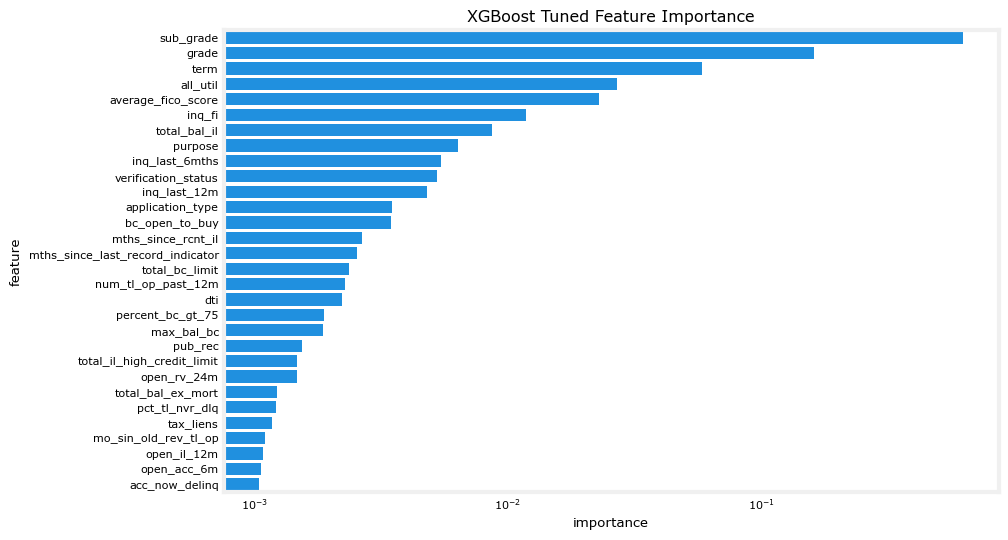

In [55]:
plt.figure(figsize=(10, 6))
plt.title('XGBoost Tuned Feature Importance')
sns.barplot(xgb_ft_importances_tuned.head(30),
            x='importance',
            y='feature',
            color=default_blue)
plt.xscale('log')
plt.show()

- After our initial hyperparameter tuning we achieved a RMSE of 0.63, which is slightly better than our default XGBoost model. We obtained a very high R2 value of 0.98, indicating that most of the various in our dependent variable can be explained by our features. Investigating our feature importance, sub grade is the biggest predictor (obviously) followed by grade and term. Moving forward we will be reducing the amount of features based on a threshold of feature importance and reevaluating.

**Reducing Features Based On Importance and Evaluating**

In [170]:
top_features_by_importance = xgb_ft_importances_tuned[
    xgb_ft_importances_tuned['importance'] >
    xgb_ft_importances_tuned['importance'].quantile(0.25)]['feature'].values

In [171]:
print(f"Original Number Of Features:{X_train.shape[1]}")
print(
    f"Number of features after threshold:{top_features_by_importance.shape[0]}"
)

Original Number Of Features:80
Number of features after threshold:60


In [164]:
numerical_cols_new, cat_cols_new = get_numerical_categorical_columns(
    X_train[top_features_by_importance])
preprocessor_new_features = create_preprocessor(
    numerical_cols=numerical_cols_new,
    categorical_cols=cat_cols_new,
    imputer_numerical=numerical_imputer,
    imputer_categorical=cat_imputer,
    encoder=encoder,
    scaler=None)

In [165]:
X_train_new_preprocessed = preprocessor_new_features.fit_transform(
    X_train[top_features_by_importance], y_train)
X_val_new_preprocessed = preprocessor_new_features.transform(
    X_val[top_features_by_importance])

In [166]:
objective_v2 = get_objective_xgb_regression(X_train_new_preprocessed,
                                            X_val_new_preprocessed, y_train,
                                            y_val, mean_squared_error)

In [172]:
study_xgb_v2 = optuna.create_study(direction='minimize')
study_xgb_v2.optimize(objective_v2, n_trials=100)

In [168]:
study_xgb_v2.best_params

{'estimators': 327,
 'learning_rate': 0.2842284611441685,
 'max_depth': 11,
 'min_child_weight': 9,
 'subsample': 0.9268298079234232,
 'colsample_bytree': 0.8933665147174131,
 'xgb_lambda': 2.498000036209515e-05,
 'xgb_alpha': 4.551537910763485e-06}

In [169]:
study_xgb_v2.best_value

0.6303802728652954

- After reducing our features based on a quantile threshold (< 0.25) we re-ran our hyperparameter tuning and evaluated the model once again. This regression task was much quicker computationally which allowed us the freedom to do more extensive tuning compared to our other models. Our RMSE has increased up to 0.63 indicating that even though the features displayed low importance they still contributed a small amount to the final predictions.Moving forward we will be evaluating our tuned model that performed superior.

**Final Model Evaluation**

In [56]:
y_preds = xgb_tuned_pipeline.predict(X_test)
rmse = mean_squared_error(y_test, y_preds, squared=False)
r2 = r2_score(y_test, y_preds)
print(f'Root Mean Squared Error: {rmse}')
print(f'R-Squared: {r2}')

Root Mean Squared Error: 0.6204567551612854
R-Squared: 0.9834514666008335


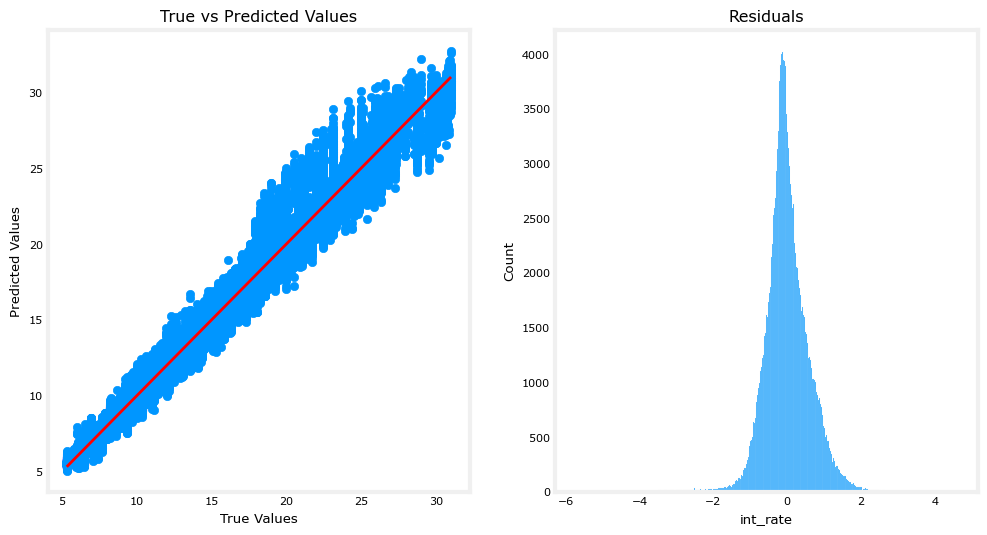

In [57]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.scatter(y_test, y_preds)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red',
         linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.subplot(1,2,2)
residuals = y_test - y_preds
plt.title('Residuals')
sns.histplot(residuals)
plt.show()

In [176]:
X_test['predicted'],X_test['true'] = y_preds,y_test
X_test['residual'] = y_test - y_preds

In [180]:
X_test[abs(X_test['residual']) >= 5].head()

,loan_amnt,term,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,mths_since_last_record_indicator,mths_since_recent_bc_dlq_indicator,mths_since_last_major_derog_indicator,mths_since_recent_revol_delinq_indicator,mths_since_last_delinq_indicator,average_fico_score,predicted,true,residual
1083502,15475.0,60.0,F,F3,7.0,RENT,43000.0,Verified,debt_consolidation,070,NJ,19.309999,0.0,0.0,15.0,0.0,18948.0,70.400002,20.0,0.0,Individual,0.0,0.0,18948.0,0.0,0.0,0.0,0.0,119.0,0.0,NaN,2.0,7.0,2656.0,70.0,26900.0,0.0,0.0,0.0,7.0,1263.0,5396.0,57.500000,0.0,0.0,119.0,296.0,7.0,7.0,0.0,7.0,NaN,0.0,7.0,14.0,7.0,9.0,1.0,15.0,19.0,15.0,15.0,0.0,0.0,0.0,2.0,90.000000,28.600000,0.0,0.0,26900.0,18948.0,12700.0,0.0,0.0,1.0,0.0,1.0,1.0,672.0,29.295740,24.240000,-5.055740
3083,30000.0,60.0,F,F2,NaN,MORTGAGE,100000.0,Verified,debt_consolidation,272,NC,26.660000,0.0,0.0,18.0,0.0,24671.0,48.500000,28.0,0.0,Individual,0.0,258.0,306763.0,2.0,2.0,1.0,1.0,4.0,63049.0,60.0,4.0,11.0,5584.0,53.0,50900.0,1.0,0.0,2.0,13.0,17042.0,15433.0,50.200001,0.0,0.0,140.0,270.0,6.0,4.0,2.0,13.0,4.0,1.0,4.0,12.0,4.0,7.0,6.0,14.0,18.0,12.0,18.0,0.0,0.0,0.0,6.0,92.599998,75.000000,0.0,0.0,359846.0,88261.0,31000.0,75573.0,0.0,1.0,1.0,1.0,1.0,667.0,28.293159,23.129999,-5.163160
1078723,25000.0,60.0,F,F1,10.0,MORTGAGE,130000.0,Verified,debt_consolidation,328,FL,13.350000,1.0,0.0,7.0,0.0,4845.0,88.099998,14.0,0.0,Individual,0.0,52.0,216168.0,0.0,4.0,2.0,3.0,10.0,37880.0,67.0,1.0,1.0,2724.0,69.0,5500.0,4.0,0.0,5.0,4.0,30881.0,655.0,88.099998,0.0,0.0,80.0,104.0,10.0,10.0,3.0,10.0,1.0,4.0,2.0,2.0,2.0,3.0,7.0,2.0,4.0,2.0,7.0,0.0,0.0,1.0,3.0,57.099998,100.000000,0.0,0.0,245447.0,42725.0,5500.0,56275.0,0.0,0.0,1.0,1.0,1.0,667.0,28.481110,22.450001,-6.031109
1108186,18525.0,60.0,F,F2,10.0,RENT,37099.0,Verified,debt_consolidation,339,FL,30.510000,0.0,0.0,13.0,0.0,15966.0,66.199997,18.0,0.0,Individual,0.0,0.0,30342.0,1.0,1.0,0.0,0.0,36.0,14376.0,61.0,4.0,7.0,4486.0,64.0,24100.0,0.0,0.0,0.0,7.0,2758.0,2228.0,85.599998,0.0,0.0,36.0,256.0,3.0,3.0,0.0,3.0,15.0,0.0,5.0,7.0,5.0,7.0,1.0,11.0,16.0,7.0,13.0,0.0,0.0,0.0,4.0,100.000000,80.000000,0.0,0.0,47666.0,30342.0,15500.0,23566.0,0.0,0.0,0.0,0.0,0.0,702.0,28.692566,23.129999,-5.562567
743882,1250.0,36.0,F,F3,2.0,MORTGAGE,30000.0,Source Verified,home_improvement,226,VA,20.360001,0.0,0.0,7.0,1.0,13598.0,76.800003,15.0,0.0,Individual,0.0,0.0,185855.0,0.0,0.0,0.0,0.0,147.0,0.0,NaN,1.0,4.0,3909.0,77.0,17700.0,0.0,1.0,0.0,4.0,26551.0,2419.0,78.599998,0.0,0.0,147.0,152.0,8.0,8.0,1.0,16.0,16.0,0.0,3.0,4.0,3.0,5.0,1.0,6.0,13.0,4.0,7.0,0.0,0.0,0.0,1.0,100.000000,66.699997,1.0,0.0,185300.0,13598.0,11300.0,0.0,1.0,0.0,0.0,0.0,0.0,667.0,29.993935,24.990000,-5.003935


**Saving Model & Testing Data**

In [59]:
dump(xgb_tuned_pipeline,'xgb_int_rate_pipeline')

['xgb_int_rate_pipeline']

- After a few iterations and trying out different features based on importance, our model that included all of the features performed best. On our test set we achieved an r-squared value of 98% and RMSE of 0.62. That means that on average, our models predictions deviate from the actual values by 0.62, which is pretty good. We also plotted the true vs predicted values and the residuals to get more of an overview of our models performance. We can see that as the true value gets higher our model struggles with accurate predictions, this could be due to the fact that these occur less frequently and the model did not have as many examples to learn from.

**Conclusion**:  
The data showed clear trends regarding the features contributing to predicting interest rates. Features such as grade, sub-grade, term, fico scores, and other credit-related attributes influenced our model's predictions. We achieved an RMSE of 0.62, indicating the accuracy of our model's predictions. From a business perspective, automating this task with such precision can significantly save time and enhance efficiency.

**Suggestions for Improvement**:  
While our model performed very well, there is always room for improvement. As we saw, our model started to struggle more as the risk and interest rates got higher. Performing more feature engineering or collecting more data in order to improve the model's accuracy with higher-risk loans would be beneficial.